# Traffic Event Distrubution

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
%matplotlib inline

In [2]:
records=pd.read_csv('random_sample_data_MQ.csv',iterator=True,chunksize=10**5,low_memory=False)

mylist=[]
for chunk in records:
    mylist.append(chunk[['Type','StartTime(UTC)','EndTime(UTC)','City','LocalTimeZone']])
    
records=pd.concat(mylist).apply(pd.to_datetime,errors='ignore').dropna().\
            rename(columns={'StartTime(UTC)':'Start','EndTime(UTC)':'End'})

In [3]:
records['LocalTimeZone'].unique()

array(['EST', 'PST', 'EDT', 'CST', 'CDT', 'MST', 'PDT', 'MDT'],
      dtype=object)

In [4]:
dic={'EST':datetime.timedelta(hours=-4), 'EDT':datetime.timedelta(hours=-4),
     'MDT':datetime.timedelta(hours=-6), 'MST':datetime.timedelta(hours=-6),
     'CDT':datetime.timedelta(hours=-5), 'CST':datetime.timedelta(hours=-5), 
     'PDT':datetime.timedelta(hours=-7), 'PST':datetime.timedelta(hours=-7)}

records['Start']=records['Start']+records['LocalTimeZone'].map(lambda x:dic[x])

In [5]:
records.shape

(1871672, 5)

## Hourly

We need to find the frequency of events during different hours of a day.(Considering the quite long time of the accidetents like construction, we only care about events start time.)

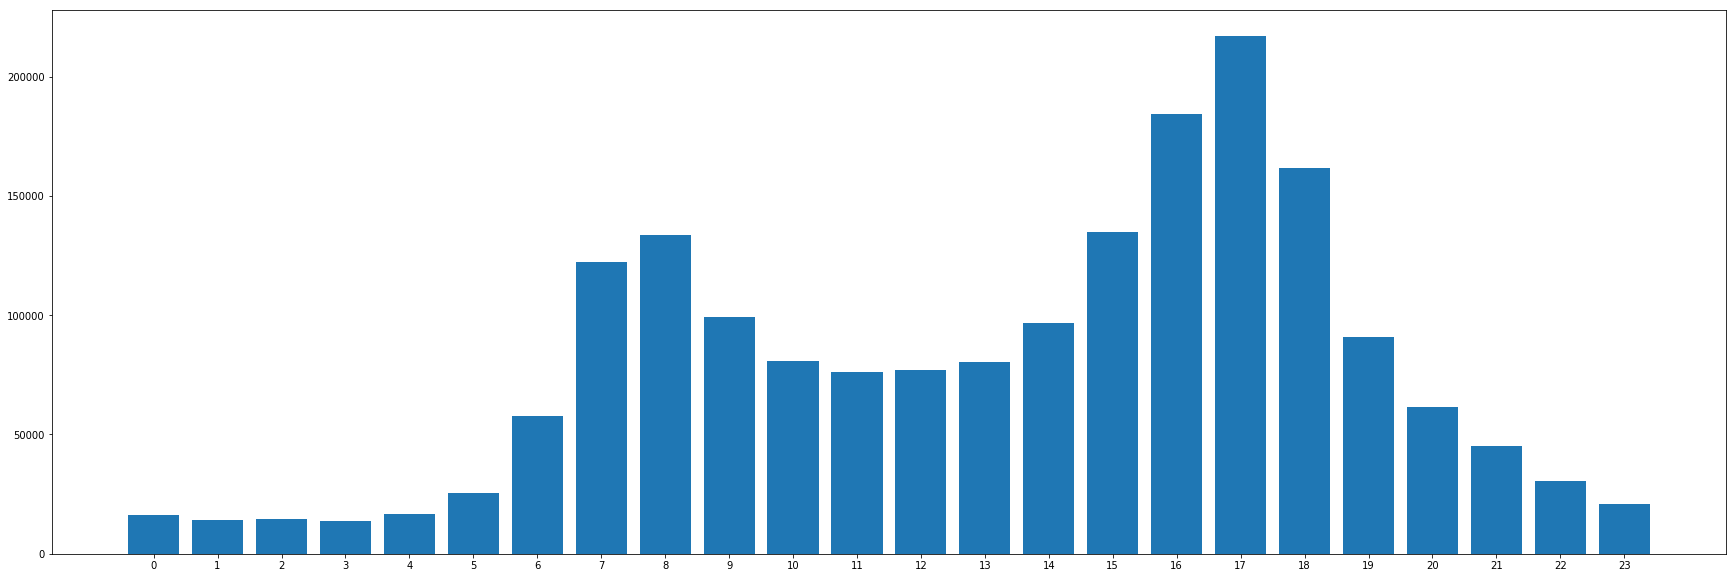

In [6]:
plt.figure(figsize=(30, 10))
start_time = records['Start'].map(lambda x:x.hour).value_counts().sort_index().to_dict()
plt.bar(range(len(start_time.keys())), start_time.values())
_ =plt.xticks(range(len(start_time.keys())), start_time.keys())

There are two peak for the overall events: 17:00 and 8:00.(Decreasing)

### Different types of events

In [7]:
def hourly_distribution(df,ax,title):
    start_time = df['Start'].map(lambda x:x.hour).value_counts().sort_index().to_dict()
    ax.bar(range(len(start_time.keys())), start_time.values(),tick_label=list(start_time.keys()))
    ax.set_title(title, fontdict={'fontsize': 16, 'fontweight': 'bold'})

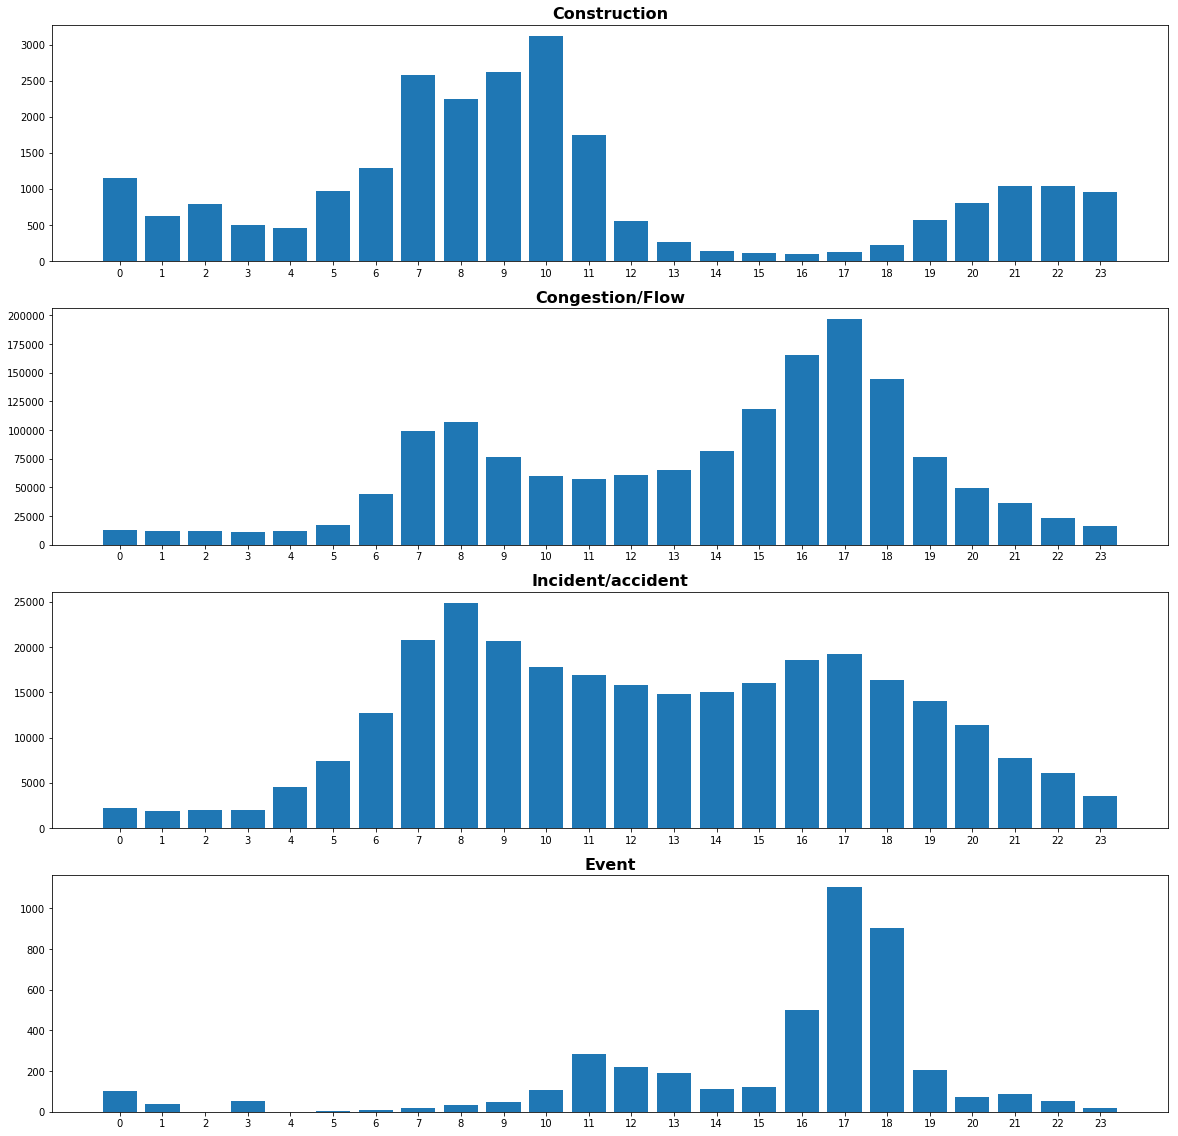

In [8]:
fg, axes = plt.subplots(4, 1, figsize=(20, 20))
kinds=records.Type.unique()

for i in range(len(kinds)):
    hourly_distribution(records[records['Type']==kinds[i]],axes[i],kinds[i])

The peaks for different events(decreasing):  
Congestion/Flow: 17：00; 8:00   
Incident/Accident: 8:00; 17:00    
Event: 27:00  
Construction: 10:00

### Major cities and other cities
To find the special points of the pattern for those major cities, we need to define major cities first.

In [9]:
cities=records['City'].value_counts()[:10].index
cities

Index(['Los Angeles', 'Houston', 'Miami', 'New York', 'Atlanta', 'Chicago',
       'Dallas', 'Austin', 'Brooklyn', 'Seattle'],
      dtype='object')

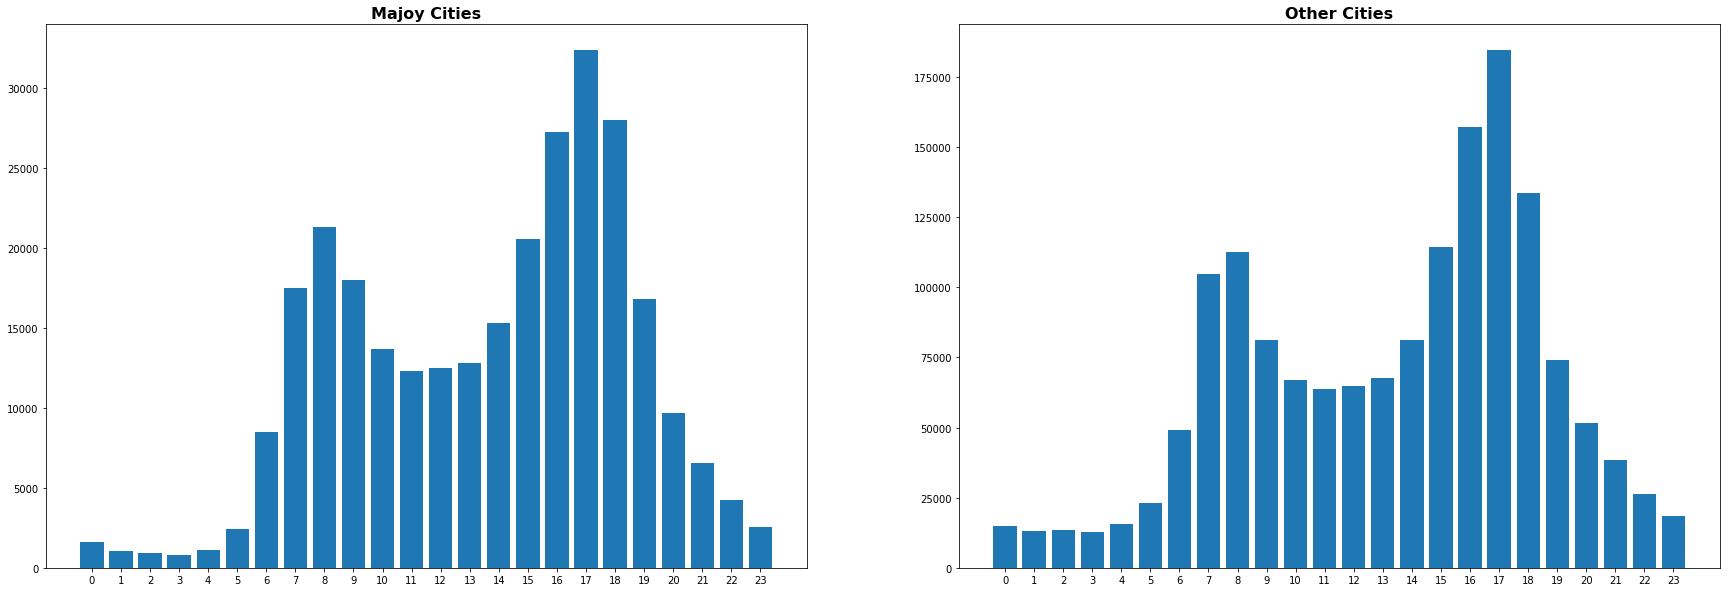

In [10]:
fg, axes = plt.subplots(1, 2, figsize=(30, 10))
major_cities=records.loc[records['City'].isin(cities)]
other_cities=records.loc[records['City'].isin(cities)==False]

hourly_distribution(major_cities,axes[0],'Majoy Cities')
hourly_distribution(other_cities,axes[1],'Other Cities')

The distribution of major cities and the distribution of other cities are quite similar. We could observe the distribution of different types.

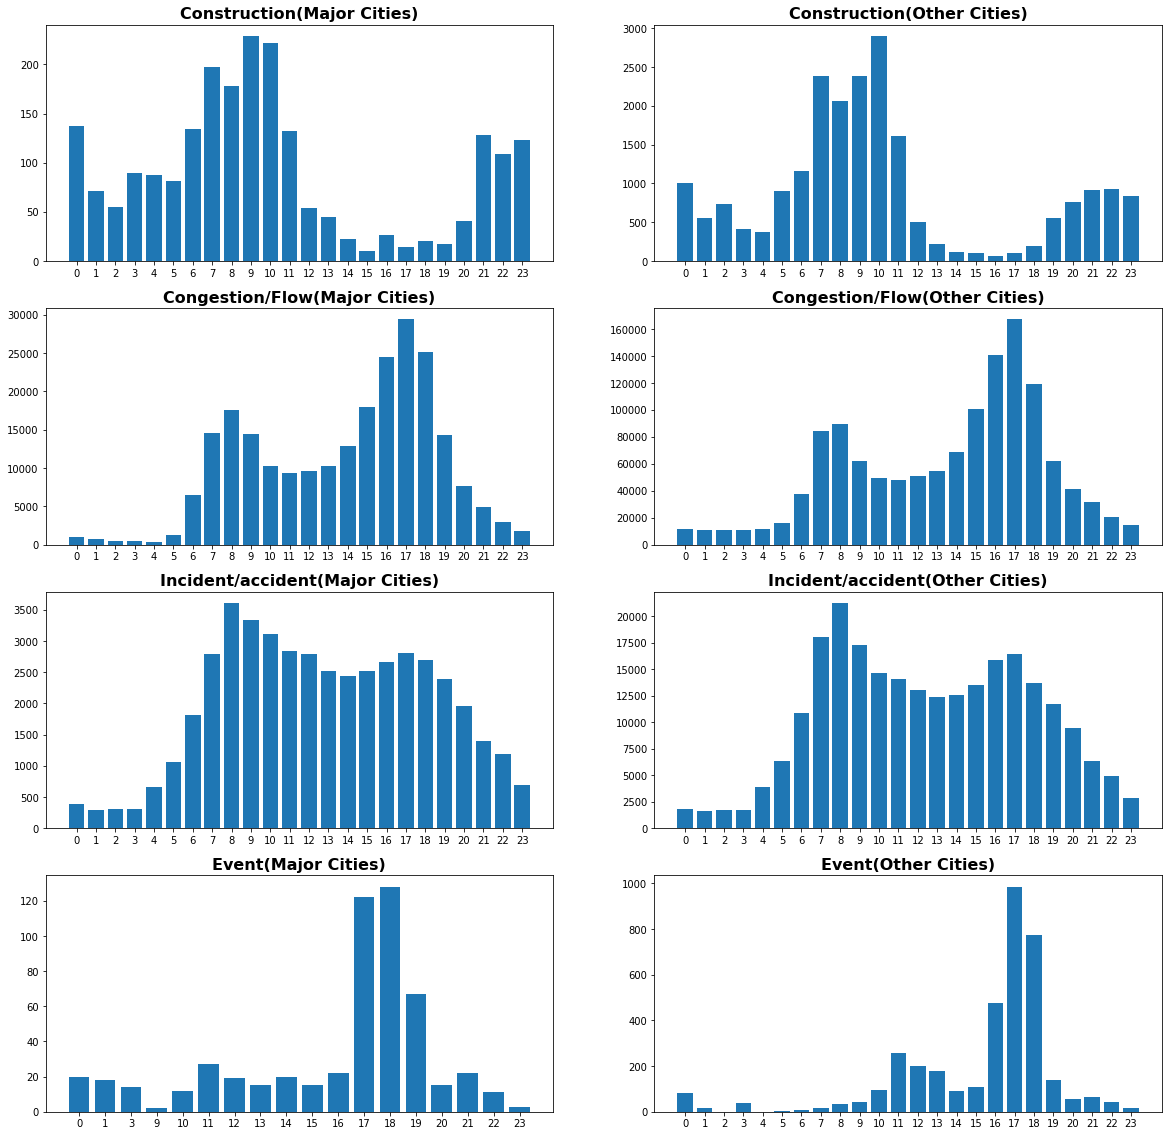

In [11]:
fg, axes = plt.subplots(4, 2, figsize=(20, 20))

for i in range(len(kinds)):
    hourly_distribution(major_cities[major_cities['Type']==kinds[i]],axes[i][0],kinds[i]+"(Major Cities)")
for i in range(len(kinds)):
    hourly_distribution(other_cities[other_cities['Type']==kinds[i]],axes[i][1],kinds[i]+"(Other Cities)")

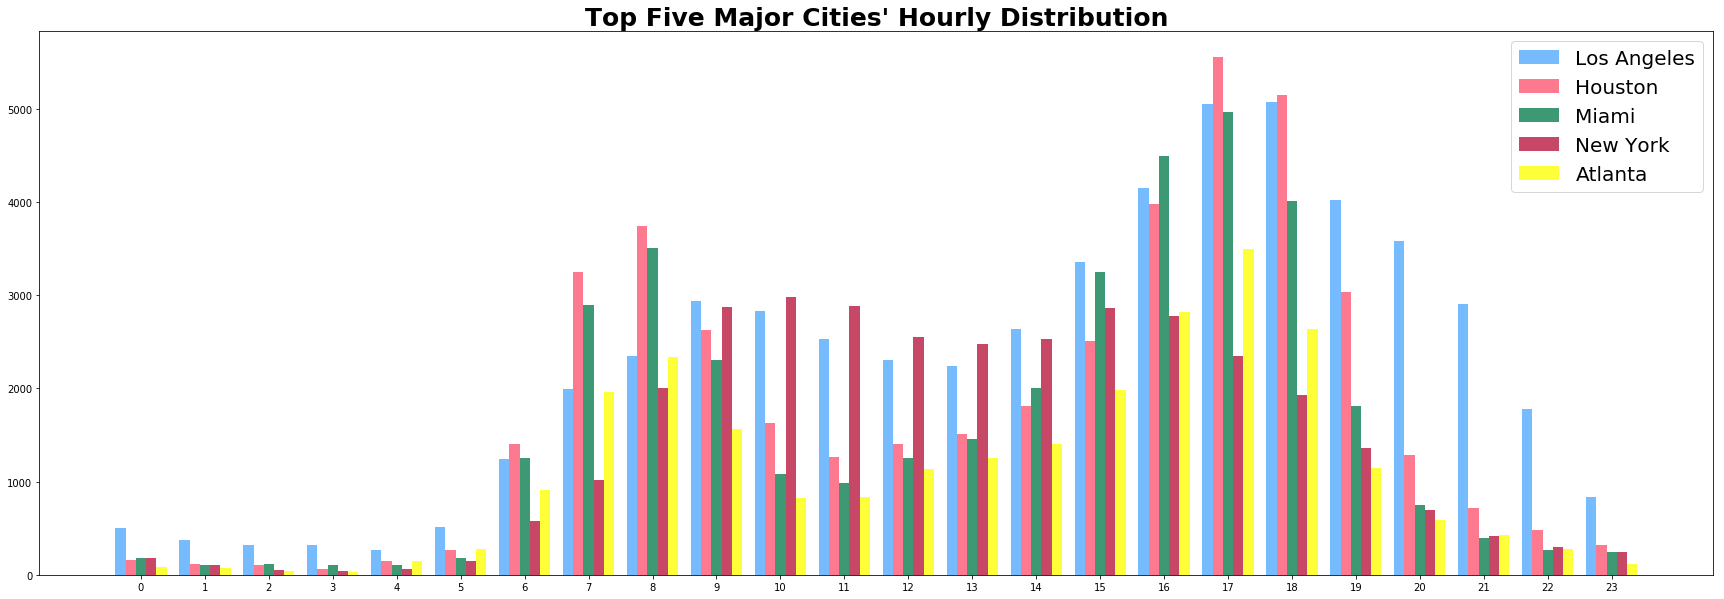

In [12]:
top_five=cities[:5]
plt.figure(figsize=(30,10))

x =list(range(24))  
total_width, n = 0.8, 5  
width = total_width / n  
cl=['lemon yellow','deep rose','ocean green','carnation','sky blue']
for city in top_five:
    target=records.loc[records['City']==city]
    start_time = target['Start'].map(lambda x:x.hour).value_counts().sort_index().to_dict()
    plt.bar(x, start_time.values(), width=width, label=city,fc ='xkcd:'+cl.pop())
    for i in range(len(x)):
        x[i]+=width
plt.xticks([i+2*width for i in range(24)],range(24))
plt.legend(prop = {'size':20})
plt.title("Top Five Major Cities\' Hourly Distribution", fontdict={'fontsize': 25, 'fontweight': 'bold'})
pass

Those top cities have similar pattern.

### Weekdays and weekends

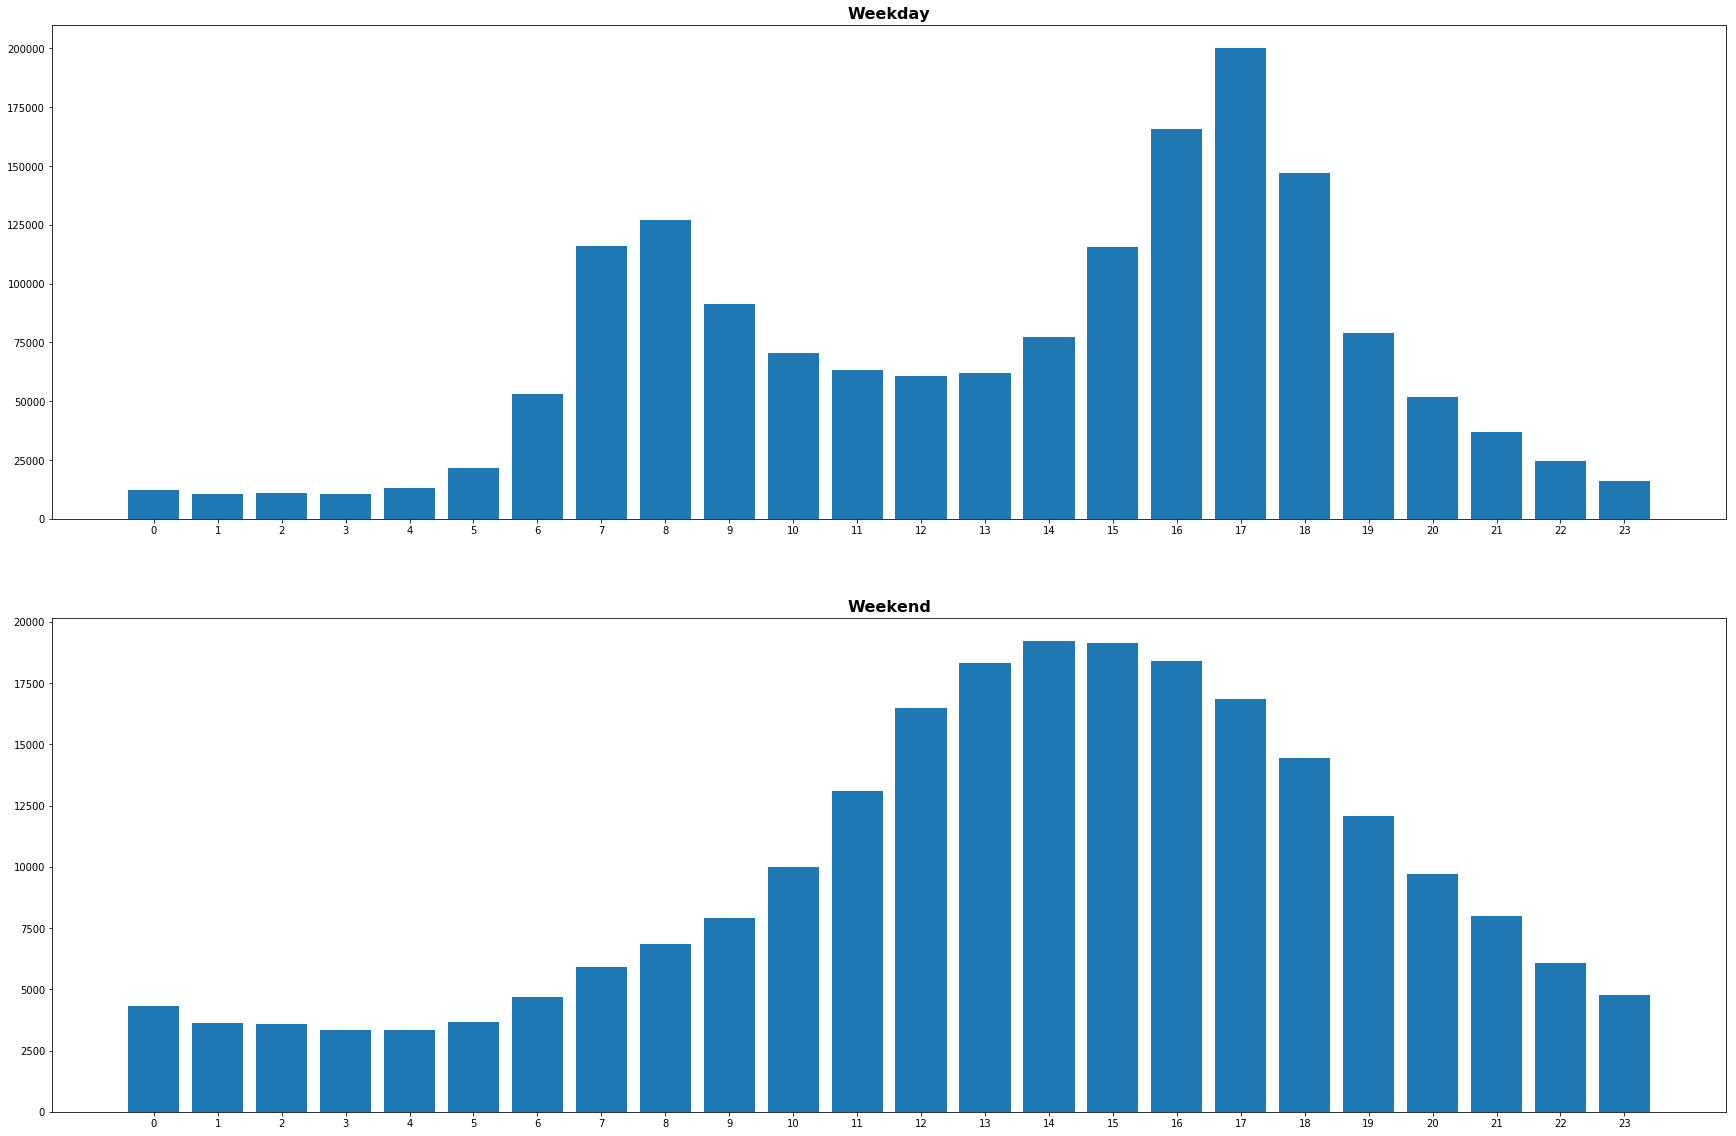

In [13]:
weekday_if=records['Start'].map(lambda x:x.weekday()) <5
weekday=records.loc[weekday_if]
weekend=records.loc[weekday_if==False]

fg, axes = plt.subplots(2, 1, figsize=(30, 20))
hourly_distribution(weekday,axes[0],'Weekday')
hourly_distribution(weekend,axes[1],'Weekend')

The peaks for weekdays(decreasing): 21:00; 12：00  
The peaks for weekends(decreasing): 0:00; 19:00

For various types:

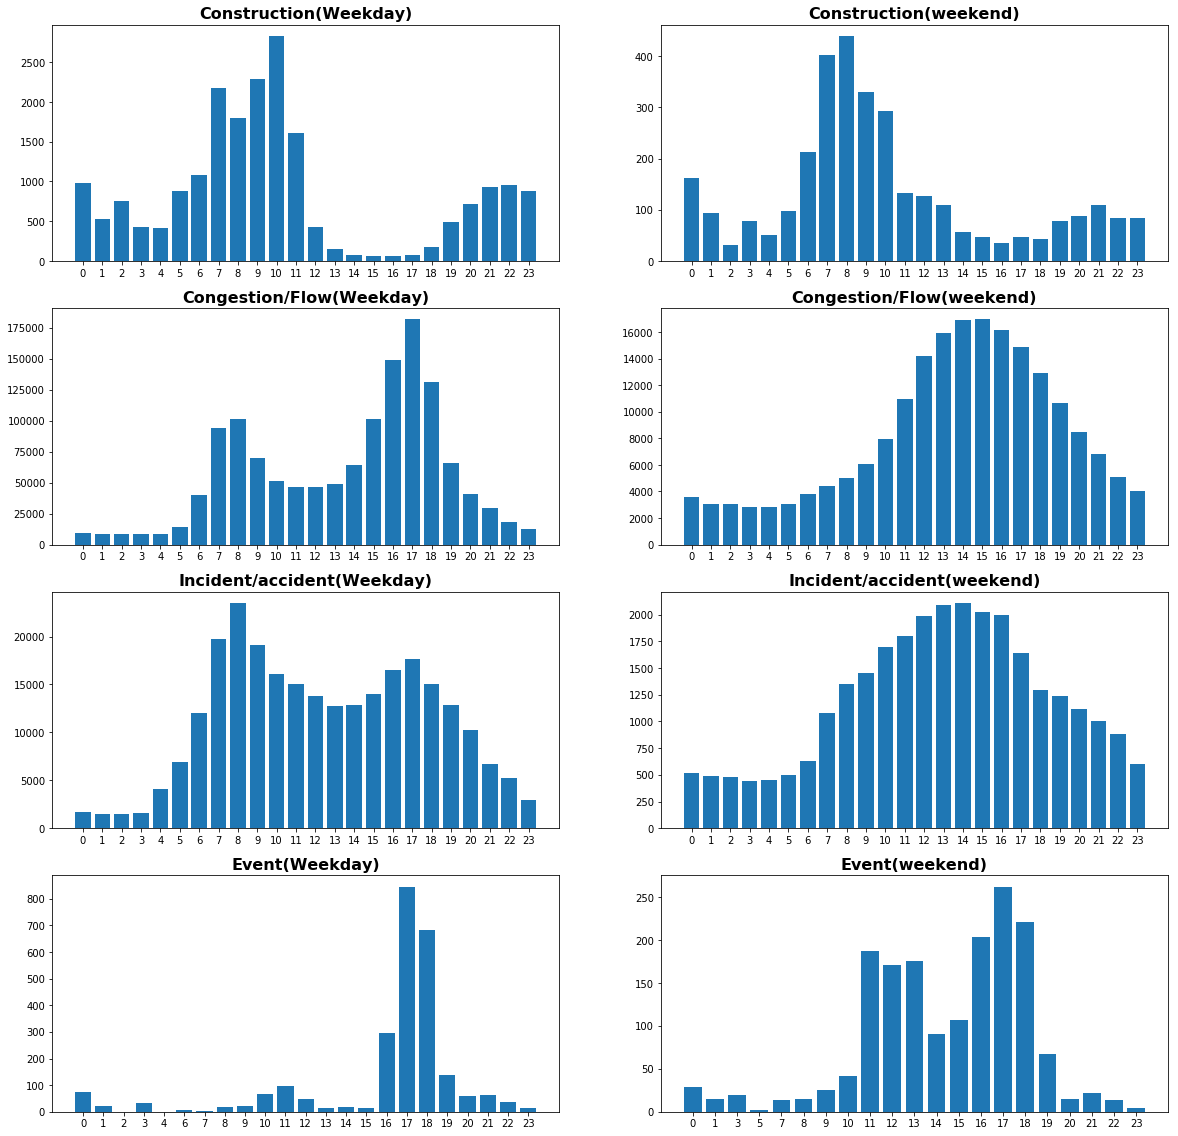

In [14]:
fg, axes = plt.subplots(4, 2, figsize=(20, 20))

for i in range(len(kinds)):
    hourly_distribution(weekday[weekday['Type']==kinds[i]],axes[i][0],kinds[i]+"(Weekday)")
for i in range(len(kinds)):
    hourly_distribution(weekend[weekend['Type']==kinds[i]],axes[i][1],kinds[i]+"(weekend)")

Apprently, the major different between peaks is mainly caused by incidents/accidents and congestions. The two types of events both meets the pattern.

On the other hand, events in weekend happens frequently in 11:00-18:00 comparing to that in weekdays.

## Daily

We need to find the frequency of events during different days of a week.(Considering the quite long time of the accidetents like construction, we only care about events start time.)

In [15]:
def daily_distribution(df,ax,title):
    start_time = df['Start'].map(lambda x:x.weekday()).value_counts().sort_index().to_dict()
    ax.bar(range(len(start_time.keys())), start_time.values(),tick_label=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
    ax.set_title(title, fontdict={'fontsize': 16, 'fontweight': 'bold'})

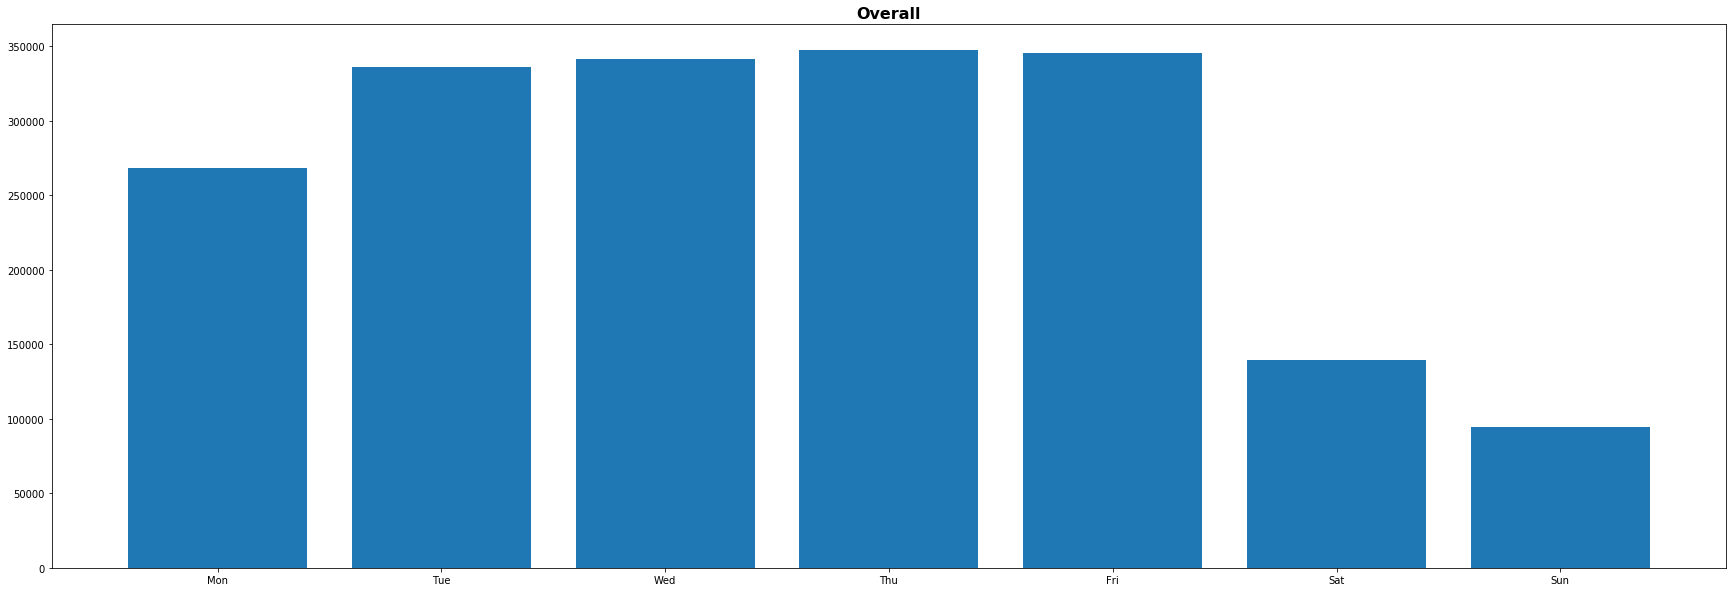

In [16]:
fg, axes = plt.subplots(1, 1, figsize=(30, 10))
daily_distribution(records,axes,'Overall')

Order of days' frequency:

In [17]:
records['Start'].map(lambda x:x.isoweekday()).value_counts().rename()

4    347293
5    345117
3    341390
2    336222
1    267874
6    139614
7     94162
dtype: int64

There are two apprent patern:  
1. events happen more frequently in weekday than in weekend.  
2. the frequency of events is decreasing in weekday.

### Different types of events

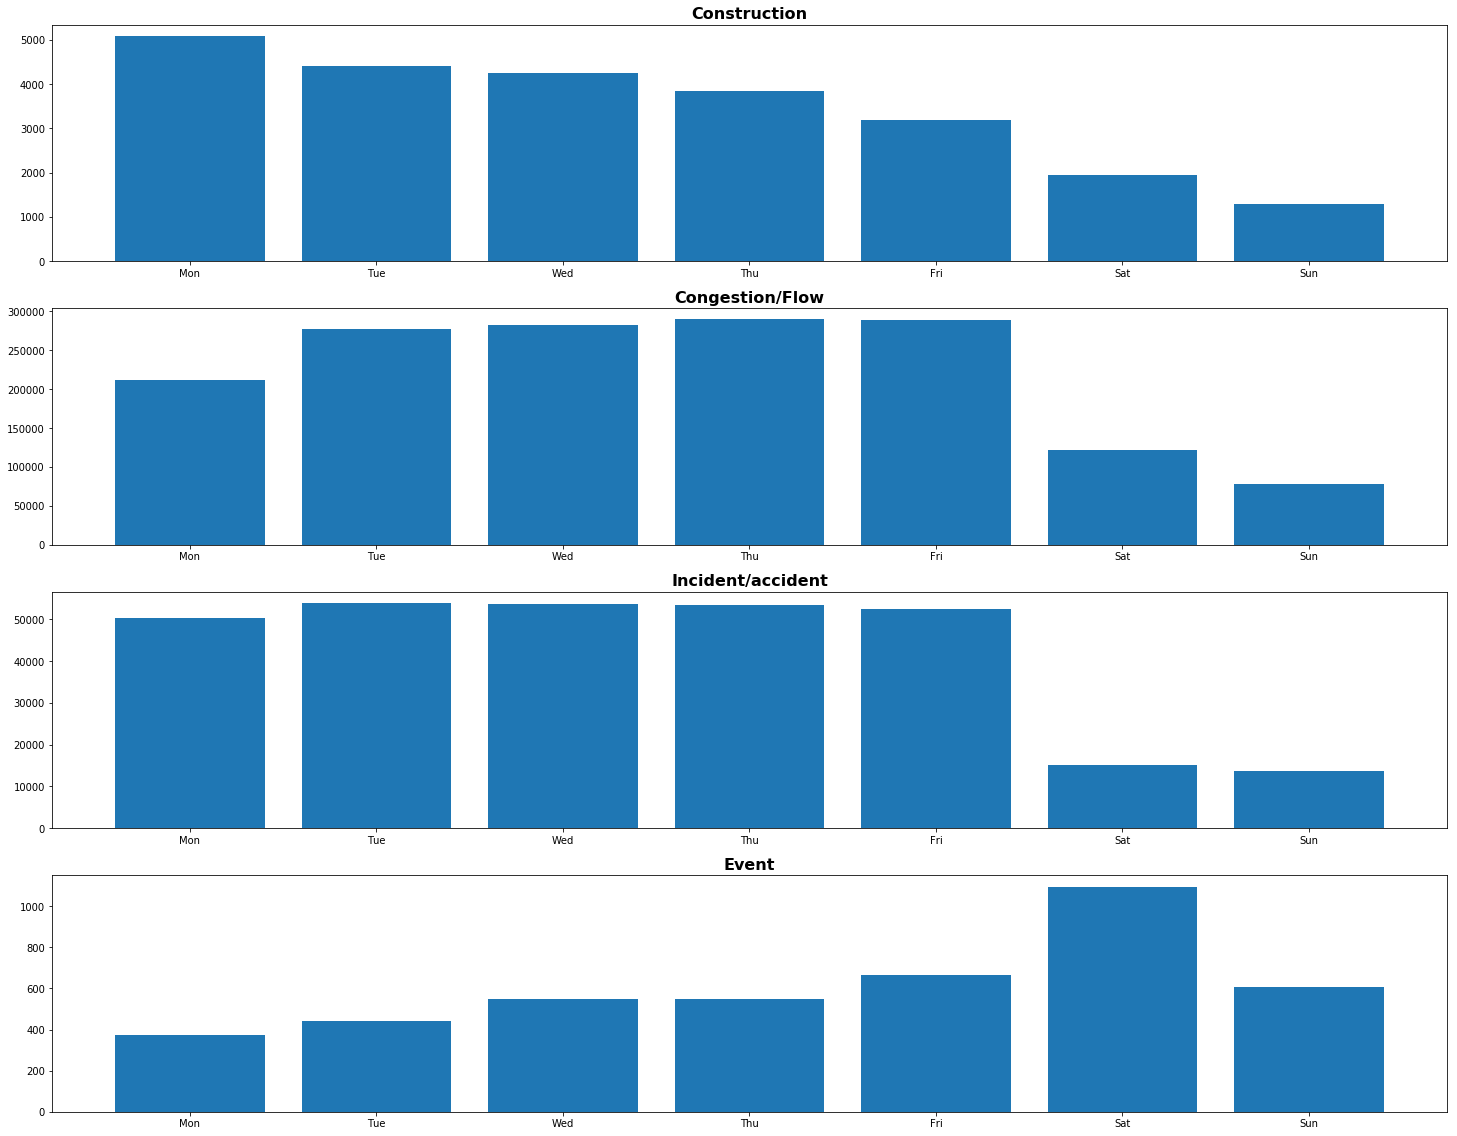

In [18]:
fg, axes = plt.subplots(4, 1, figsize=(25, 20))

for i in range(len(kinds)):
    daily_distribution(records[records['Type']==kinds[i]],axes[i],kinds[i])

The congestion/flow and incident/accident both meet the overall two patterns, while for events accidents happen more frequently in weekend and for construction the decline trend don not exist.

### Major cities and other cities

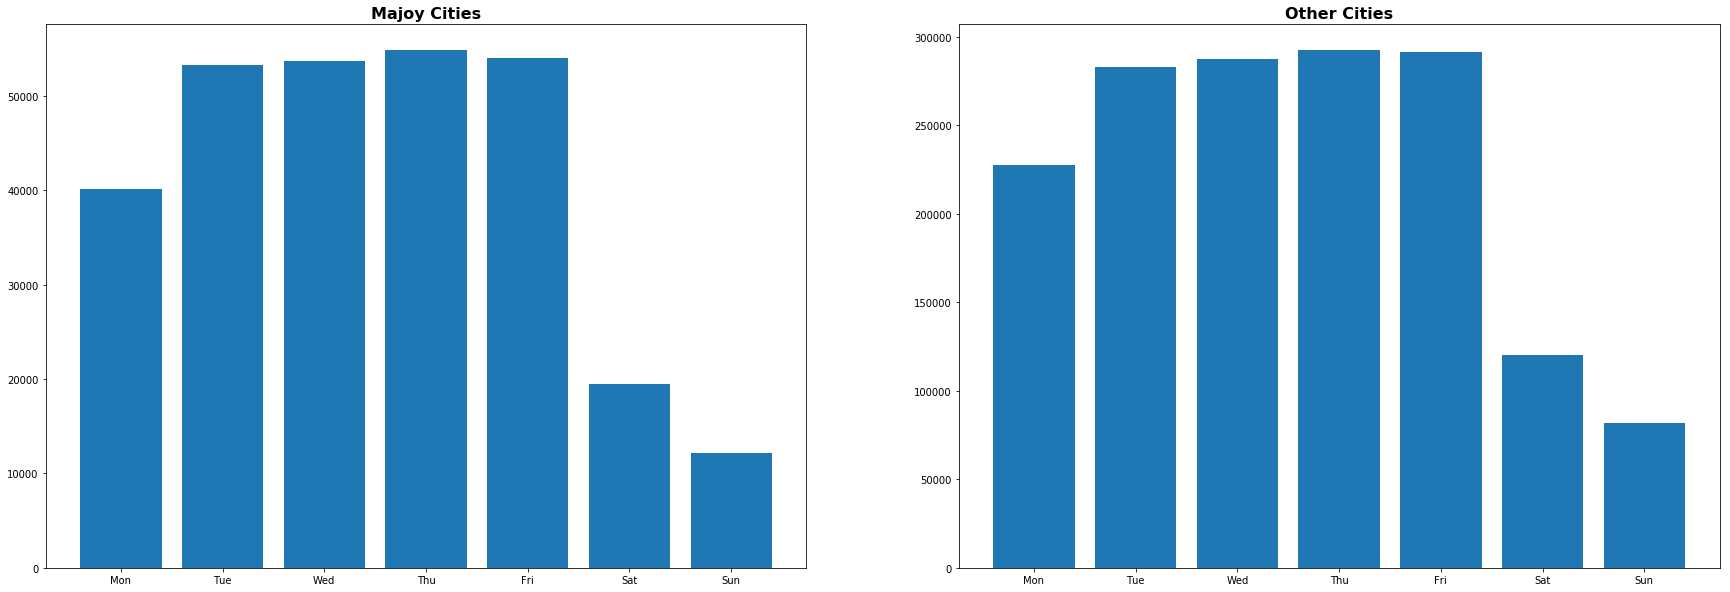

In [19]:
fg, axes = plt.subplots(1, 2, figsize=(30, 10))

daily_distribution(major_cities,axes[0],'Majoy Cities')
daily_distribution(other_cities,axes[1],'Other Cities')

It seems like no apprent differences exist.

Compare the distribution of different type.

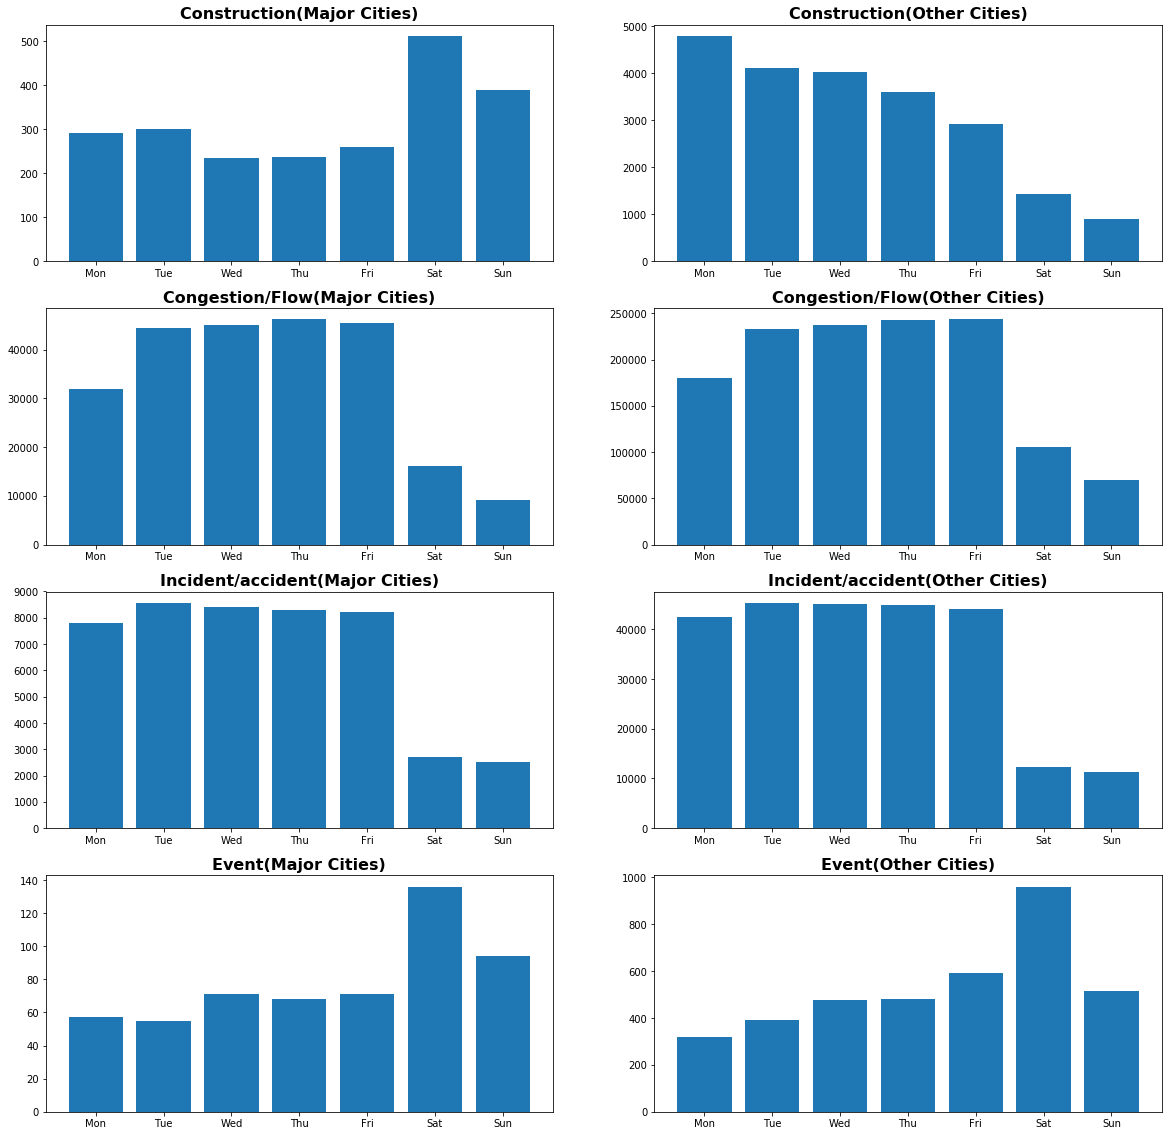

In [20]:
fg, axes = plt.subplots(4, 2, figsize=(20, 20))

for i in range(len(kinds)):
    daily_distribution(major_cities[major_cities['Type']==kinds[i]],axes[i][0],kinds[i]+"(Major Cities)")
for i in range(len(kinds)):
    daily_distribution(other_cities[other_cities['Type']==kinds[i]],axes[i][1],kinds[i]+"(Other Cities)")

There is one item should we pay attention to:
The freature of construction in major cities is totally different from that in other cities. Apprently, construction is major cities happens more frequently in weekend than in weekday, while for other cities the order is in contrast.

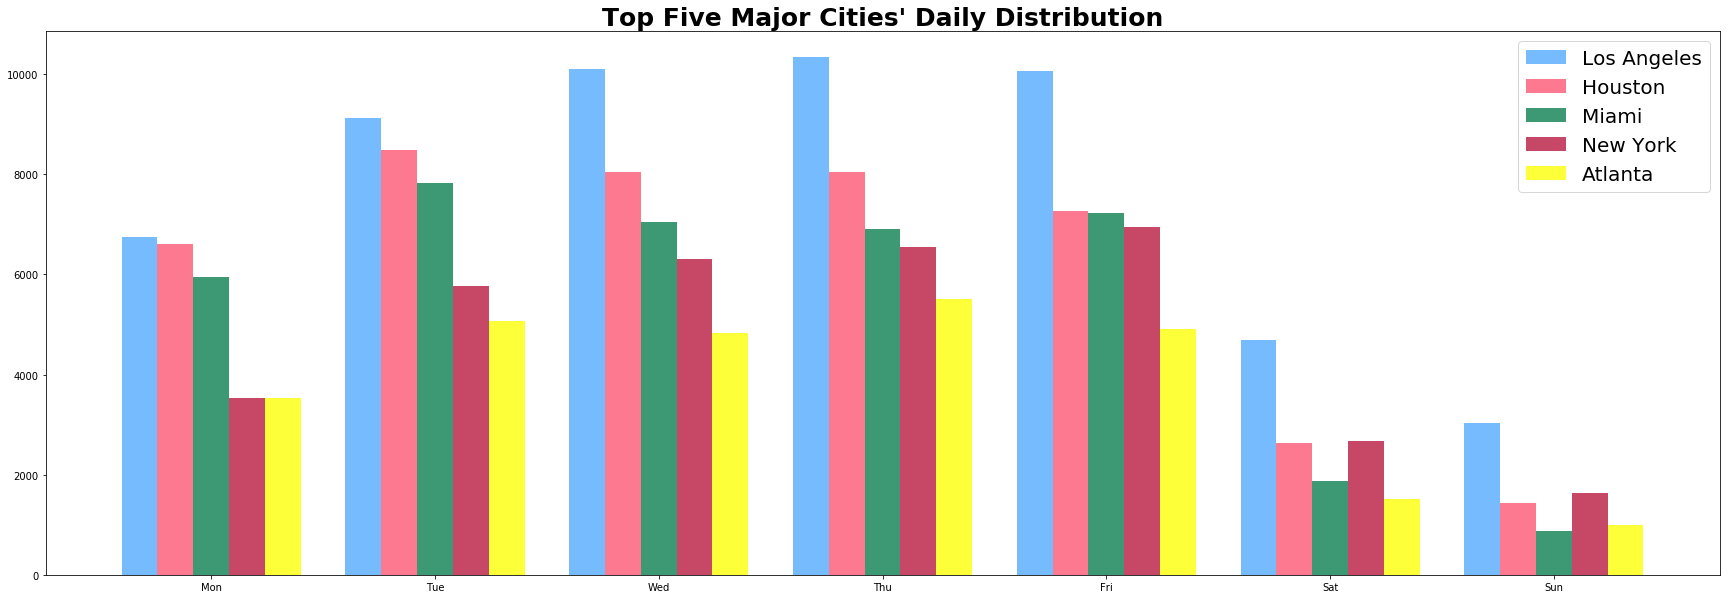

In [21]:
top_five=cities[:5]
plt.figure(figsize=(30,10))

x =list(range(7))  
total_width, n = 0.8, 5  
width = total_width / n  
cl=['lemon yellow','deep rose','ocean green','carnation','sky blue']
for city in top_five:
    target=records.loc[records['City']==city]
    start_time = target['Start'].map(lambda x:x.weekday()).value_counts().sort_index().to_dict()
    plt.bar(x, start_time.values(), width=width, label=city,fc ='xkcd:'+cl.pop())
    for i in range(len(x)):
        x[i]+=width
plt.xticks([i+2*width for i in range(7)],['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.legend(prop = {'size':20})
plt.title('Top Five Major Cities\' Daily Distribution', fontdict={'fontsize': 25, 'fontweight': 'bold'})
pass

Those top cities have similar pattern.

## monthly

### Data Preprocessing

Considering we need to analyze monthly pattern. We need to observe distributions of time for different types first.

In [22]:
min(records['Start'])
ts=pd.Series([0]*len(records),index=records['Start'])
# records=records[re?cords.apply(lambda x: x['Start']<MIN[x['Type']],axis=1)]

In [23]:
ts.resample('M').count()

Start
2012-11-30         1
2012-12-31         0
2013-01-31         3
2013-02-28         0
2013-03-31         0
2013-04-30         0
2013-05-31         0
2013-06-30         0
2013-07-31         0
2013-08-31         0
2013-09-30         0
2013-10-31         0
2013-11-30         0
2013-12-31         1
2014-01-31         0
2014-02-28         0
2014-03-31         2
2014-04-30         2
2014-05-31         0
2014-06-30         2
2014-07-31         0
2014-08-31         0
2014-09-30         3
2014-10-31         2
2014-11-30         0
2014-12-31         0
2015-01-31         4
2015-02-28         6
2015-03-31         7
2015-04-30         4
               ...  
2015-12-31        17
2016-01-31        22
2016-02-29      1145
2016-03-31      3315
2016-04-30     11296
2016-05-31     13070
2016-06-30     27837
2016-07-31     32159
2016-08-31     55167
2016-09-30     58446
2016-10-31     51680
2016-11-30     58444
2016-12-31     58098
2017-01-31     51443
2017-02-28     52130
2017-03-31     62264
2017-04

Thus, we only need to take the data from Feburary 2016 to January 2018.

In [24]:
end=datetime.datetime(2018,2,1)
start=datetime.datetime(2016,2,1)
records=records[(records['Start']>=start)&(records['Start']<end)]

We need to find the frequency of events during different days of a week.(Considering the quite long time of the accidetents like construction, we only care about events start time.)

In [25]:
def monthly_distribution(df,ax,title):
    start_time = df['Start'].map(lambda x:x.month).value_counts().sort_index().to_dict()
    ax.bar(range(len(start_time.keys())), start_time.values(),tick_label=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
    ax.set_title(title, fontdict={'fontsize': 16, 'fontweight': 'bold'})

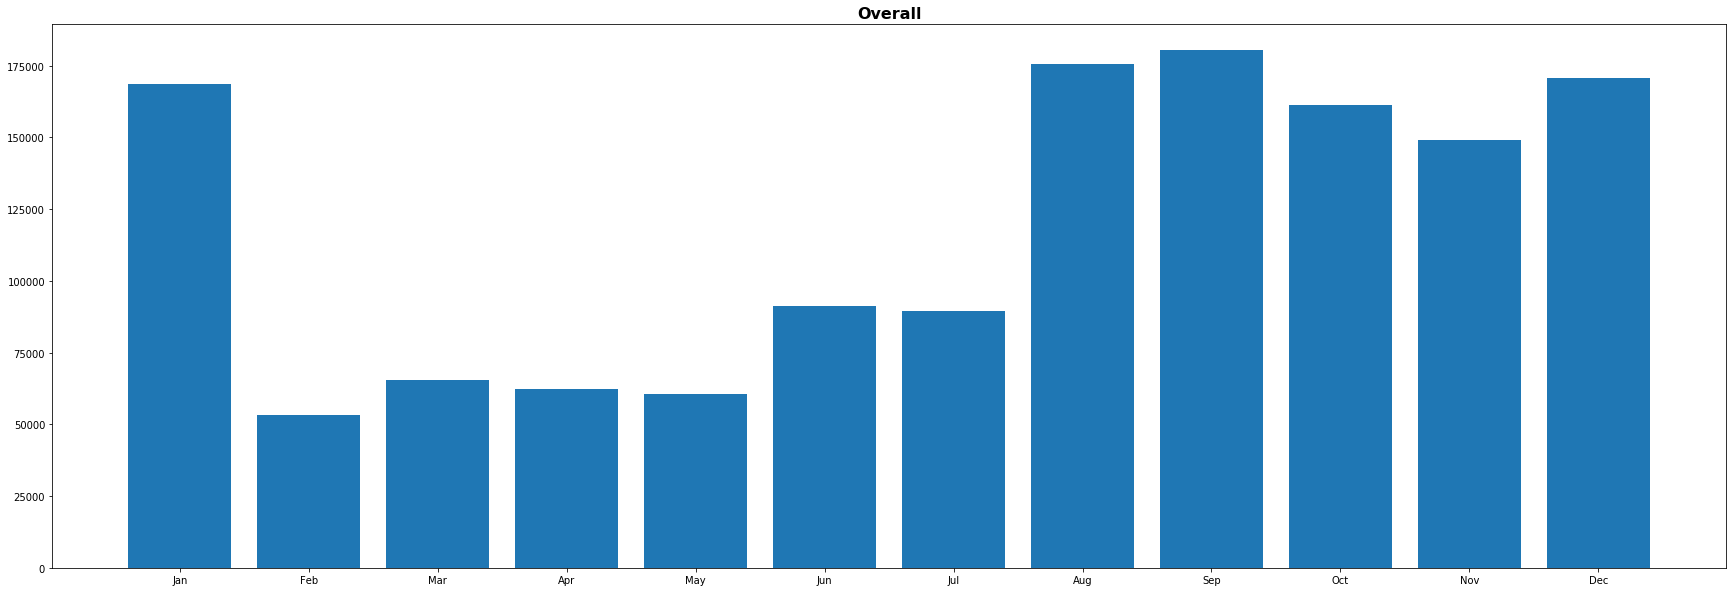

In [26]:
fg, axes = plt.subplots(1, 1, figsize=(30, 10))
monthly_distribution(records,axes,'Overall')

From Augest to January(next year), events happens more frequently.

### Different types of events

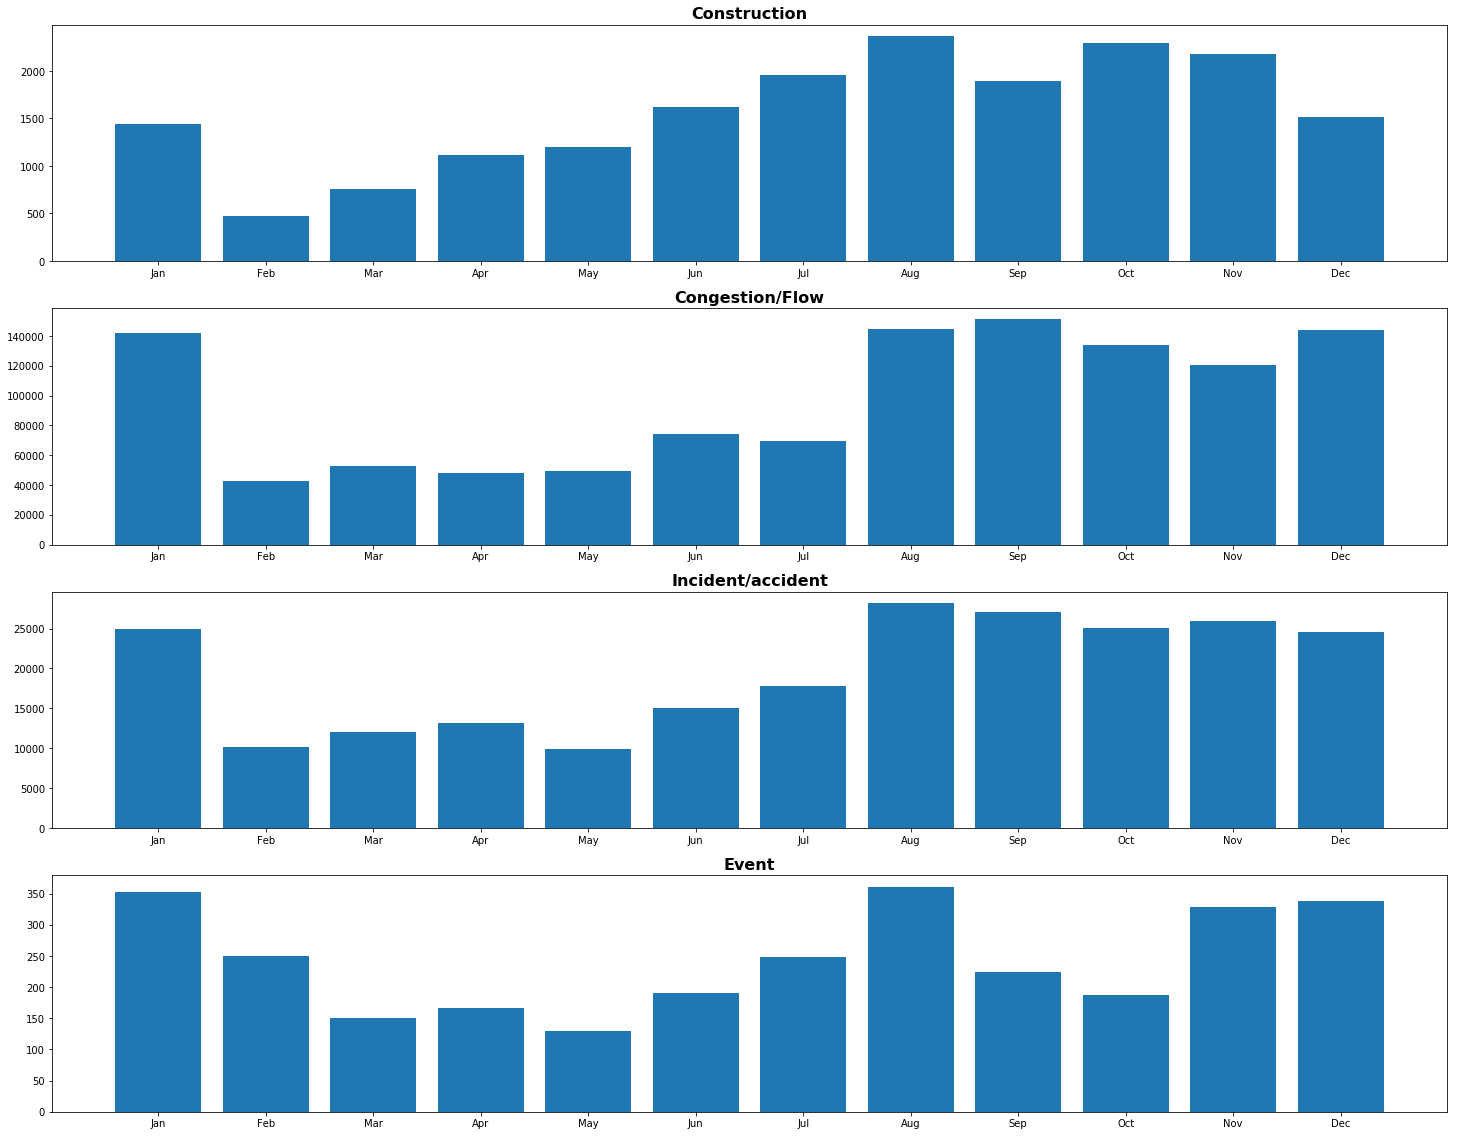

In [27]:
fg, axes = plt.subplots(4, 1, figsize=(25, 20))

for i in range(len(kinds)):
    monthly_distribution(records[records['Type']==kinds[i]],axes[i],kinds[i])

Apprently, the overall distribution's features is caused by congestion/Flow: From Augest to January, congestion/Flow happens more frequently.

Construction: happens sparsely in December, January Feburary.  
Incidents: No apprent features.  
Events: happens more frequently in Feburary.

## Major cities and other cities

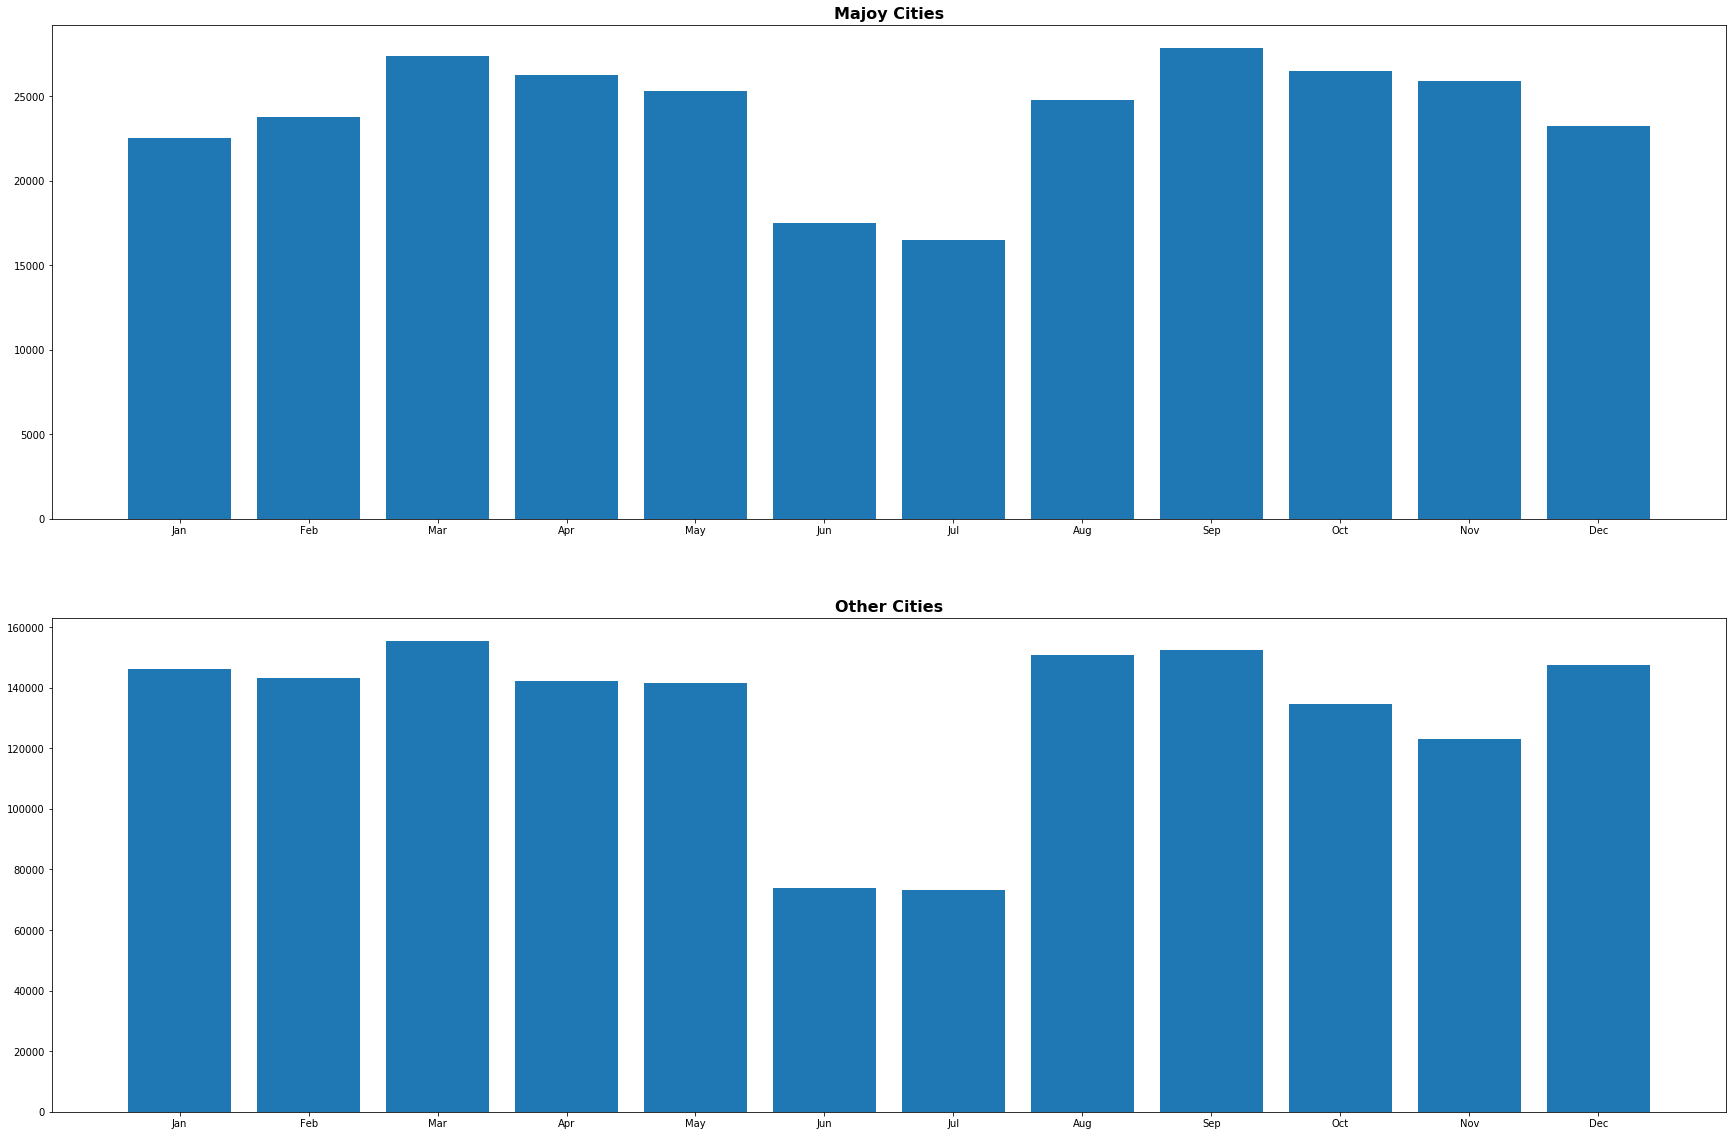

In [28]:
fg, axes = plt.subplots(2, 1, figsize=(30, 20))

monthly_distribution(major_cities,axes[0],'Majoy Cities')
monthly_distribution(other_cities,axes[1],'Other Cities')

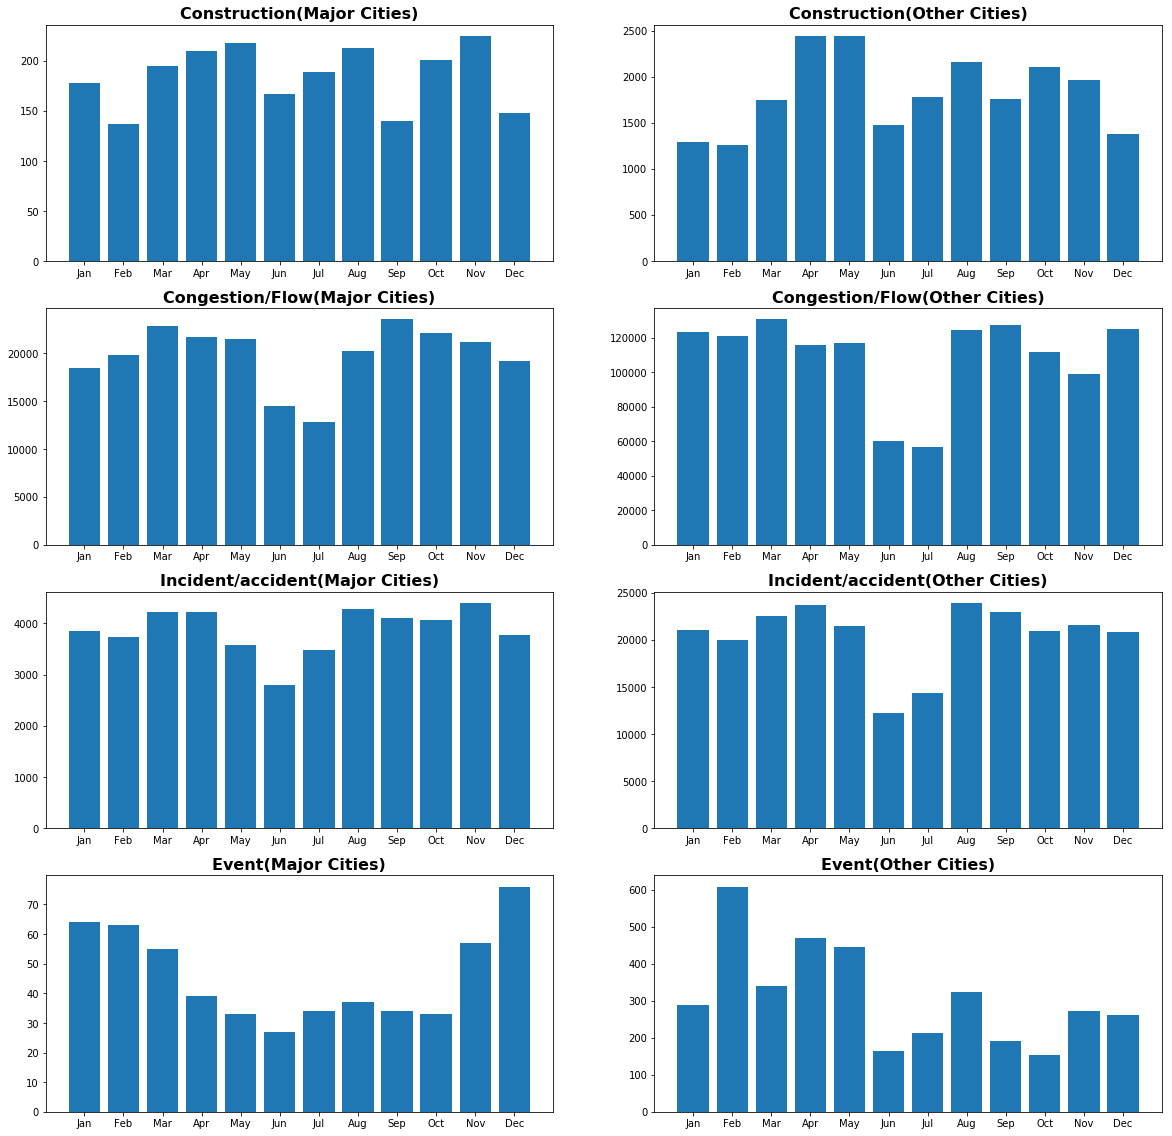

In [29]:
fg, axes = plt.subplots(4, 2, figsize=(20, 20))

for i in range(len(kinds)):
    monthly_distribution(major_cities[major_cities['Type']==kinds[i]],axes[i][0],kinds[i]+"(Major Cities)")
for i in range(len(kinds)):
    monthly_distribution(other_cities[other_cities['Type']==kinds[i]],axes[i][1],kinds[i]+"(Other Cities)")

In major cities and other cities, the patterns of construction, incident/accident and congestion/flow are similar.

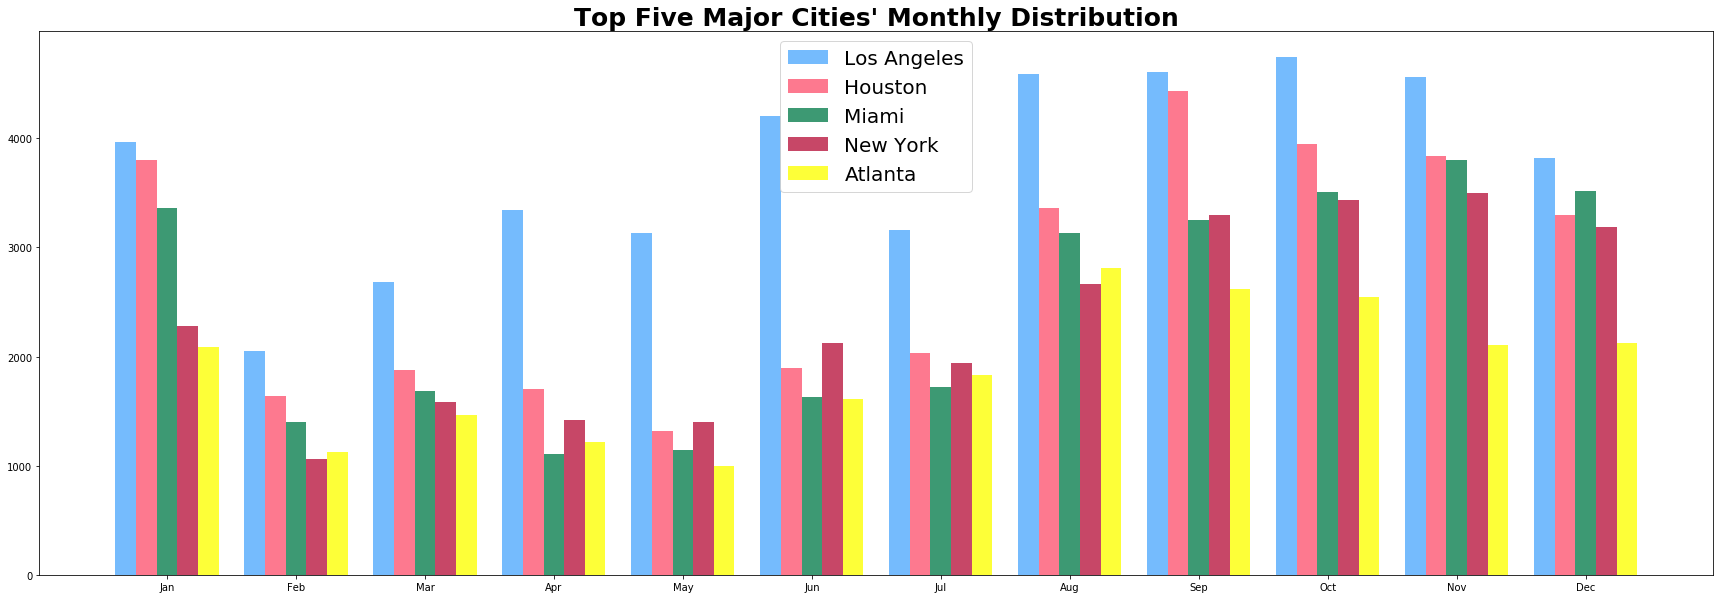

In [30]:
top_five=cities[:5]
plt.figure(figsize=(30,10))

x =list(range(12))  
total_width, n = 0.8, 5  
width = total_width / n  
cl=['lemon yellow','deep rose','ocean green','carnation','sky blue']
for city in top_five:
    target=records.loc[records['City']==city]
    start_time = target['Start'].map(lambda x:x.month).value_counts().sort_index().to_dict()
    plt.bar(x, start_time.values(), width=width, label=city,fc ='xkcd:'+cl.pop())
    for i in range(len(x)):
        x[i]+=width
plt.xticks([i+2*width for i in range(12)],['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.legend(prop = {'size':20})
plt.title('Top Five Major Cities\' Monthly Distribution', fontdict={'fontsize': 25, 'fontweight': 'bold'})
pass

Those top cities have similar pattern.

## Appendix：

### Type distribution

In [31]:
def type_distribution(part, ax, title):
    groupby = part.groupby('Type')['Type'].count()
    labels= groupby.keys()
    values = groupby.values
    ax.axis('equal')
    ax.pie(values, labels=labels)
    ax.set_title(title, fontdict={'fontsize': 16, 'fontweight': 'bold'})

Overall:

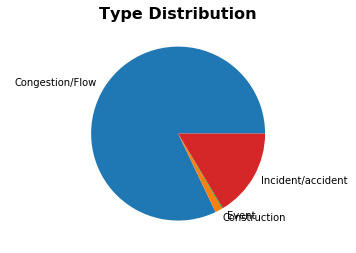

In [32]:
types = records.groupby('Type')['Type'].count()
plt.axis("equal")
plt.pie(types.values, labels=types.keys())
plt.title('Type Distribution', fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.show()

Major cities and other cities:

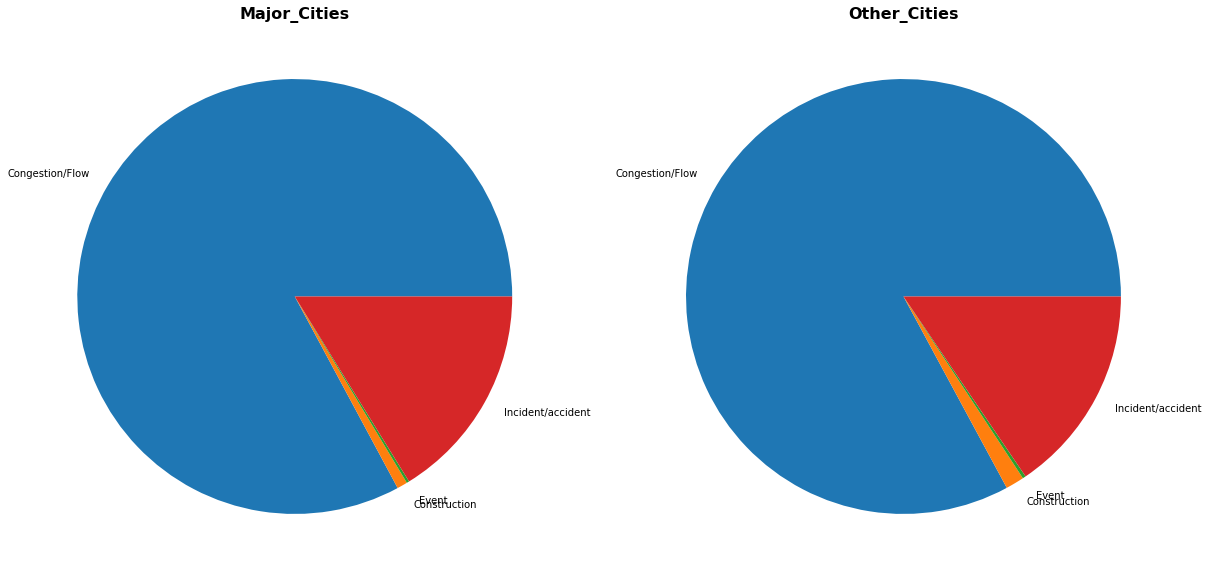

In [33]:
fg, axes = plt.subplots(1, 2, figsize=(20, 10))
type_distribution(major_cities,axes[0],'Major_Cities')
type_distribution(other_cities,axes[1],'Other_Cities')

Weekdays and weekends:

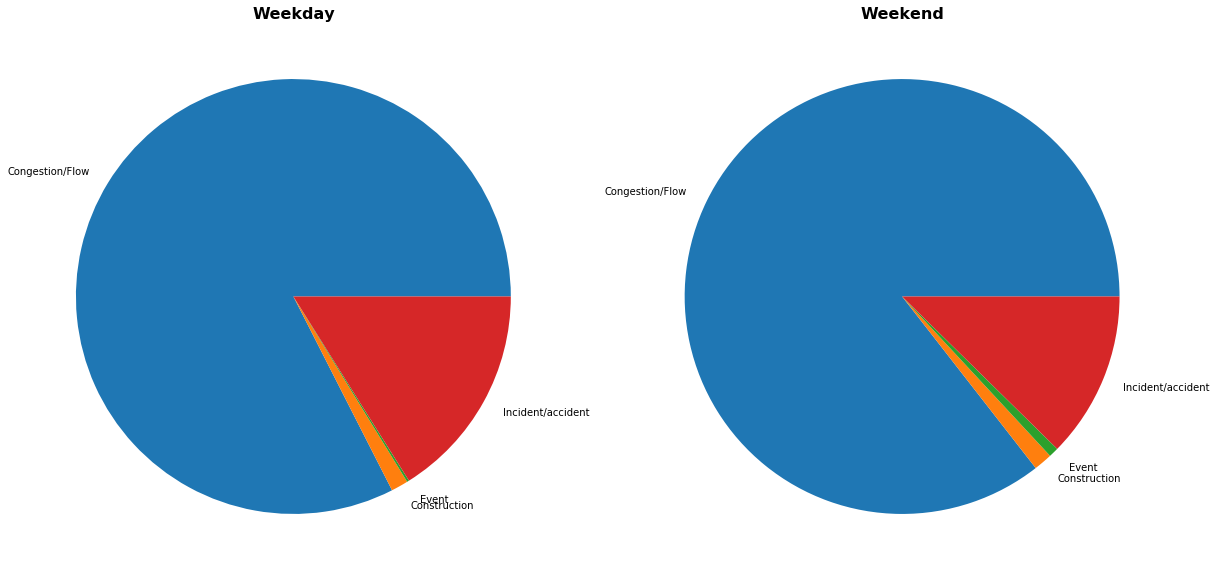

In [34]:
fg, axes = plt.subplots(1, 2, figsize=(20, 10))
type_distribution(weekday,axes[0],'Weekday')
type_distribution(weekend,axes[1],'Weekend')

## length of diffrent types

In [35]:
length=pd.concat([records['Type'],records['Start'],records['End']-records['Start']],axis=1)

### Congestion/Flow

In [36]:
sample=length[length['Type']=='Congestion/Flow']
ts=pd.Series(list(sample[0]),index=sample['Start'])
resampler = ts.resample('M').sum().div(ts.resample('M').count()).map(lambda x:x.seconds//60)

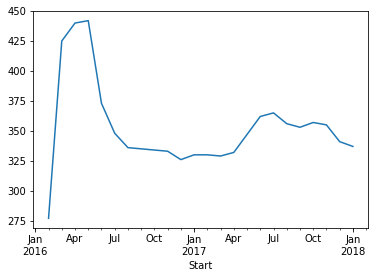

In [37]:
resampler.plot()

### Incident/Accident

In [38]:
sample=length[length['Type']=='Incident/accident']
ts=pd.Series(list(sample[0]),index=sample['Start'])
resampler = ts.resample('M').sum().div(ts.resample('M').count()).map(lambda x:x.seconds//60)

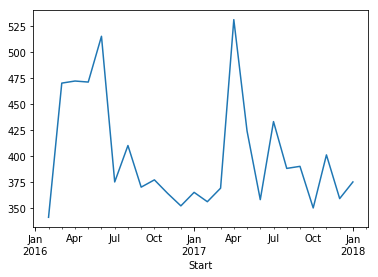

In [39]:
resampler.plot()

### Construction

In [40]:
sample=length[length['Type']=='Construction']
ts=pd.Series(list(sample[0]),index=sample['Start'])
resampler = ts.resample('M').sum().div(ts.resample('M').count()).map(lambda x:x.days)

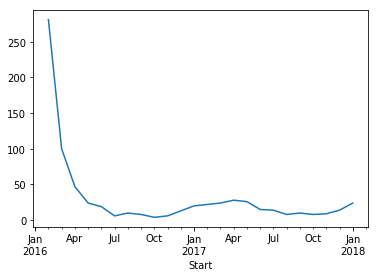

In [41]:
resampler.plot()
pass

### Event

In [42]:
sample=length[length['Type']=='Event']
ts=pd.Series(list(sample[0]),index=sample['Start'])
resampler = ts.resample('M').sum().div(ts.resample('M').count()).map(lambda x:x.seconds//60)

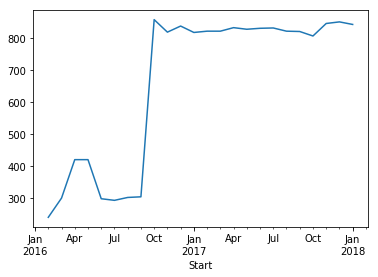

In [43]:
resampler.plot()
pass

We could find that the length of time for congestion is increasing these years and that for others decreased. However, considering that the cases in early time are quite sparse, we could not make conclusion recklessly.